In [164]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
sns.set()

from tensorflow.keras import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *

from chord_functions import *

from sklearn.metrics import *
from sklearn.model_selection import KFold

from collections import defaultdict

# Setup

In [165]:
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)

#Load all data
data = pd.read_csv('data/R10.csv')

#Remove redundant attributes. Need to keep op to split
data = data[['chord', 'op']]

#Tranform the chords using one-hot encoding before separation so train and test have same # of features
data = pd.get_dummies(data)

#Separate one opus for testing purposes
opus = 131
test = data.loc[data['op'] == opus]
train = data.loc[data['op'] != opus]

#Remove the opus feature
test = test.drop(columns='op')
train = train.drop(columns='op')


In [162]:
test.shape[0]/data.shape[0]

0.09129738387613455

# Sequence generation

In [166]:
#Create input sequences of length 10, predict the 11:th
seq_length = 10

train_in, train_out = generate_sequences(train, train, seq_length)

test_in, test_out = generate_sequences(test, test, seq_length)

# Model

In [167]:
def lstm(lstm_x, lstm_y, optimizer, loss, metrics):
    model = Sequential()
    
    model.add(LSTM(256, return_sequences=True, input_shape=(lstm_x.shape[1], lstm_x.shape[2])))
    
    model.add(Dropout(0.5))
    
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    
    model.add(LSTM(64, return_sequences=False))
    
    model.add(Dropout(0.3))
    
    model.add(Dense(lstm_y.shape[1], activation='softmax'))

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    return model

In [168]:
#Define hyperparameters
optimizer = 'Adam'
loss = 'categorical_crossentropy'
metrics = ['accuracy']


# Training

### Hyperparameters

In [169]:
cv_folds = 5
epochs = 30
verbose = 1

#Save the weights whenever validation accuracy is increased
checkpoint = ModelCheckpoint(
    'weights.{epoch:02d}-{val_acc:.4f}.hdf5',
    monitor='val_acc', 
    verbose=0,        
    save_best_only=False
)
# Stop the learning process if we havent improved validation accuracy for 10 epochs
earlystop = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1)
callbacks_list = [checkpoint, earlystop]     

### Cross validate

In [170]:
#Set up how to split the data
kf = KFold(n_splits=cv_folds, random_state=seed, shuffle=True)

model_storage = []
current_fold = 1

for train_fold, test_fold in kf.split(train_in):
    
    #Create model
    model = lstm(train_in, train_out, optimizer, loss, metrics)
    
    print("Current fold = {}".format(current_fold))
    current_fold += 1
    
    #Define the training fold
    train_x = train_in[train_fold]
    train_y = train_out[train_fold]
    
    #Define the test fold
    test_x = train_in[test_fold]
    test_y = train_out[test_fold]
    
    #Train on the folds
    model.fit(train_x,
              train_y,
              epochs = epochs,
              verbose = verbose,
              validation_data = (test_x, test_y),
              callbacks = callbacks_list)
    
    #Store the final model objects in a vector, one for each fold
    model_storage.append(model)

Current fold = 1
Train on 20415 samples, validate on 5104 samples
Epoch 1/30
20415/20415 [==============================] - 180s 9ms/step - loss: 3.7126 - acc: 0.1051 - val_loss: 3.6340 - val_acc: 0.1205
Epoch 2/30
20415/20415 [==============================] - 168s 8ms/step - loss: 3.6206 - acc: 0.1205 - val_loss: 3.4995 - val_acc: 0.1520
Epoch 3/30
20415/20415 [==============================] - 178s 9ms/step - loss: 3.4901 - acc: 0.1452 - val_loss: 3.4249 - val_acc: 0.1614
Epoch 4/30
20415/20415 [==============================] - 161s 8ms/step - loss: 3.4254 - acc: 0.1588 - val_loss: 3.3624 - val_acc: 0.1750
Epoch 5/30
20415/20415 [==============================] - 178s 9ms/step - loss: 3.3467 - acc: 0.1687 - val_loss: 3.2965 - val_acc: 0.1816
Epoch 6/30
20415/20415 [==============================] - 151s 7ms/step - loss: 3.2813 - acc: 0.1776 - val_loss: 3.2497 - val_acc: 0.1985
Epoch 7/30
20415/20415 [==============================] - 167s 8ms/step - loss: 3.2401 - acc: 0.1895 - val

20415/20415 [==============================] - 120s 6ms/step - loss: 3.0202 - acc: 0.2448 - val_loss: 3.1349 - val_acc: 0.2228
Epoch 14/30
20415/20415 [==============================] - 120s 6ms/step - loss: 2.9830 - acc: 0.2535 - val_loss: 3.1405 - val_acc: 0.2228
Epoch 15/30
20415/20415 [==============================] - 120s 6ms/step - loss: 2.9444 - acc: 0.2598 - val_loss: 3.1384 - val_acc: 0.2275
Epoch 16/30
20415/20415 [==============================] - 120s 6ms/step - loss: 2.9082 - acc: 0.2674 - val_loss: 3.1313 - val_acc: 0.2218
Epoch 17/30
20415/20415 [==============================] - 120s 6ms/step - loss: 2.8644 - acc: 0.2751 - val_loss: 3.1260 - val_acc: 0.2245
Epoch 18/30
20415/20415 [==============================] - 120s 6ms/step - loss: 2.8213 - acc: 0.2879 - val_loss: 3.1461 - val_acc: 0.2296
Epoch 19/30
20415/20415 [==============================] - 120s 6ms/step - loss: 2.7738 - acc: 0.2946 - val_loss: 3.1565 - val_acc: 0.2259
Epoch 20/30
20415/20415 [==============

Epoch 23/30
20416/20416 [==============================] - 120s 6ms/step - loss: 2.5026 - acc: 0.3462 - val_loss: 3.2301 - val_acc: 0.2287
Epoch 00023: early stopping


# Results

### Cross validation results

In [195]:
# Save the results for each fold
f1 = [18, 2.9134, 0.2695, 3.1211, 0.2424]
f2 = [17, 2.7723, 0.2934, 3.0947, 0.2398]
f3 = [18, 2.8213, 0.2879, 3.1461, 0.2296]
f4 = [20, 2.8314, 0.2804, 3.1630, 0.2351]
f5 = [18, 2.7380, 0.2963, 3.1409, 0.2359]

res_df = pd.DataFrame([f1, f2, f3, f4, f5], columns=['Epochs', 'Loss', 'Acc', 'ValLoss', 'ValAcc'])
res_df.loc['mean'] = res_df.mean()
res_df.index.name = 'Fold'
display(res_df)
pd.DataFrame.to_csv(res_df, './results/cv.csv')

,Epochs,Loss,Acc,ValLoss,ValAcc
Fold,,,,,
0,18.0,2.91340,0.2695,3.12110,0.24240
1,17.0,2.77230,0.2934,3.09470,0.23980
2,18.0,2.82130,0.2879,3.14610,0.22960
3,20.0,2.83140,0.2804,3.16300,0.23510
4,18.0,2.73800,0.2963,3.14090,0.23590
mean,18.2,2.81528,0.2855,3.13316,0.23656


### Test data results

In [185]:
#Load the best models
m1 = load_model('cross_fold_weights/best/weights.17-0.2398.hdf5')
m2 = load_model('cross_fold_weights/best/weights.18-0.2296.hdf5')
m3 = load_model('cross_fold_weights/best/weights.18-0.2359.hdf5')
m4 = load_model('cross_fold_weights/best/weights.18-0.2424.hdf5')
m5 = load_model('cross_fold_weights/best/weights.20-0.2351.hdf5')

best_models = [m1, m2, m3, m4, m5]

In [ ]:
prob_dist = 0
for model in best_models:   
    # Retrieve the probability distributions for the classes
    prob_dist += model.predict(test_in)
    
# Generate chord predictions from the average probability distribution
predicted = remap(prob_dist/cv_folds, test.columns.values)

# Generate actual from the test
actual = remap(test_out, test.columns.values)

print(classification_report(actual, predicted))

## Learning Curves

Final values
acc
0.3085966201220369
valacc
0.2380485893416928
loss
2.6874020318730394
valoss
3.1942022123306897



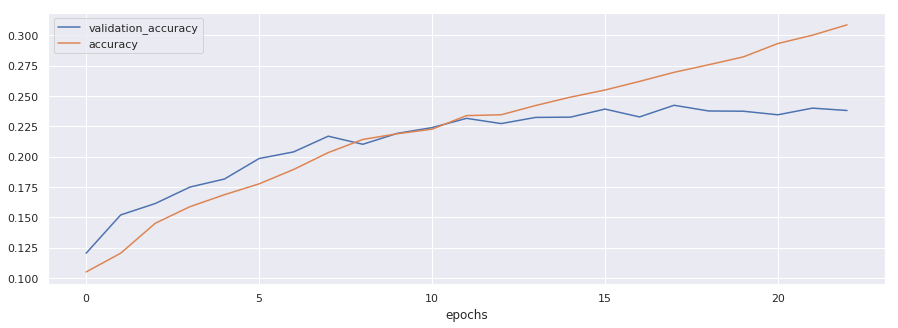

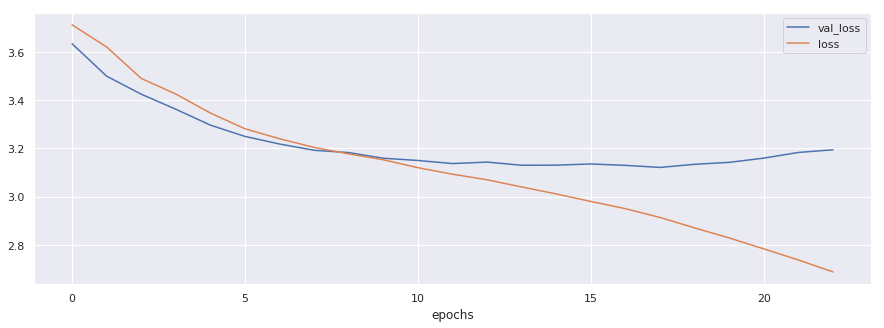

Final values
acc
0.3423952975650935
valacc
0.23177899686520376
loss
2.5145363693461533
valoss
3.1856346377011002



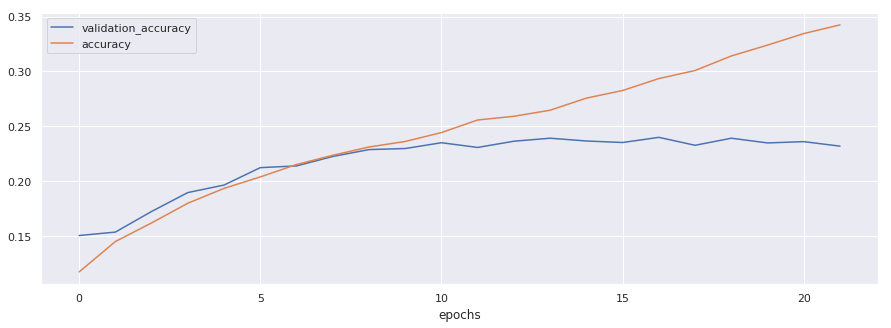

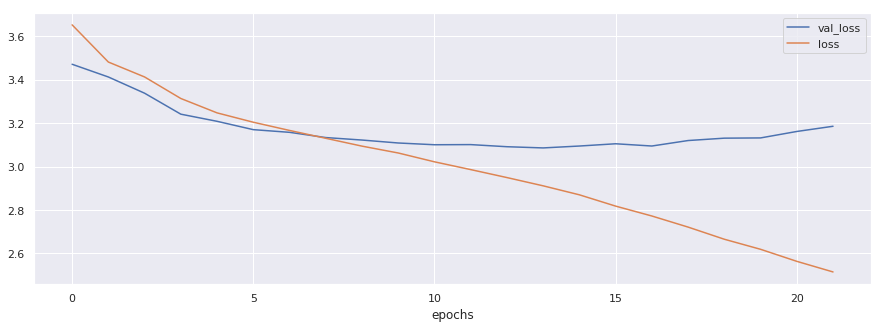

Final values
acc
0.33088415378657676
valacc
0.21963166144200627
loss
2.577137966679207
valoss
3.210257835896411



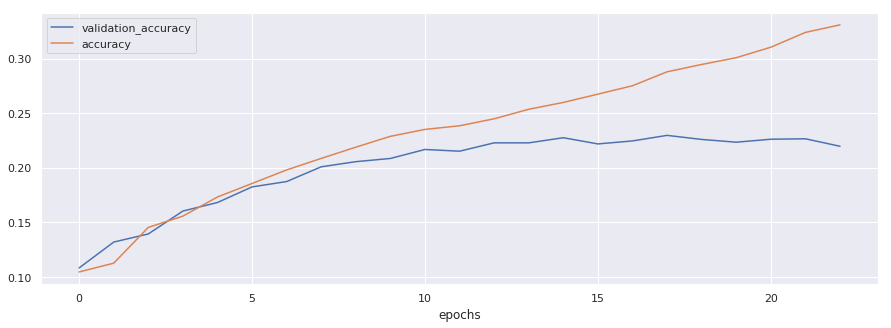

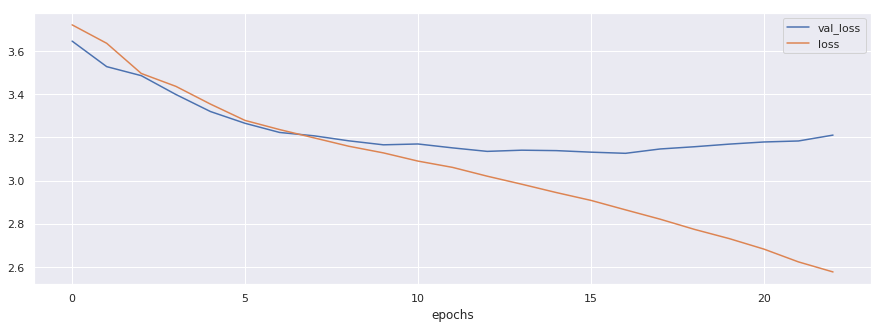

Final values
acc
0.33426402153672174
valacc
0.227076802507837
loss
2.5855222707865666
valoss
3.2800672069238646



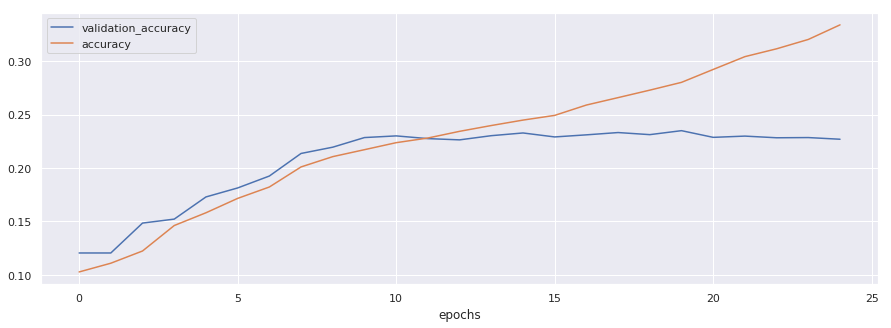

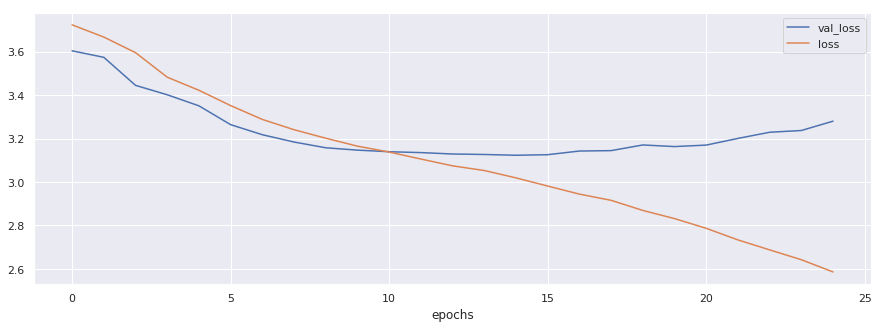

Final values
acc
0.3461990595611285
valacc
0.2286890064843047
loss
2.5026480551797397
valoss
3.230110747380138



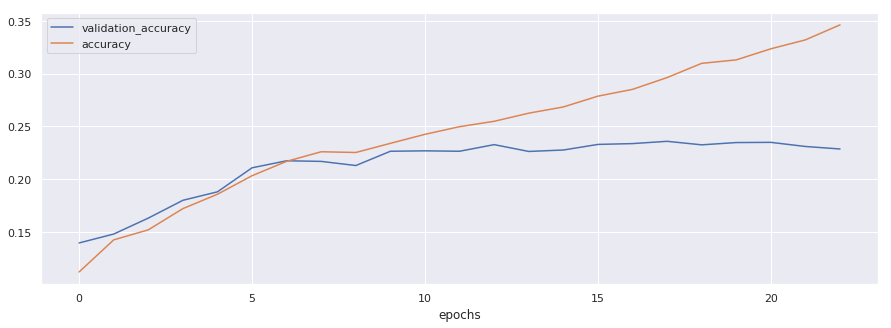

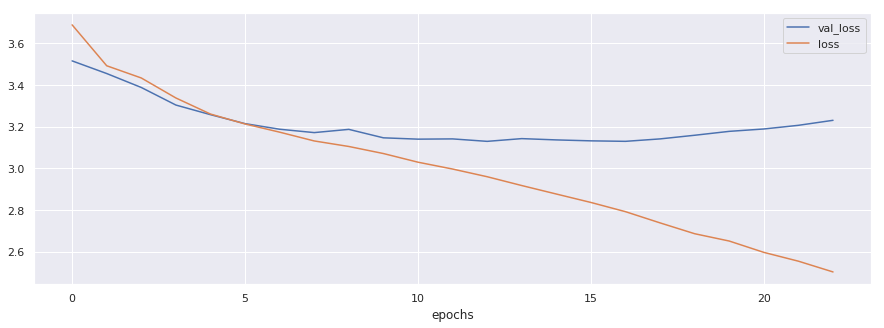

In [197]:
def disp_results(model_vector):
    """
    Takes a model vector plots the evolution of the metrics as well as the final scores for each model
    """
    for model in model_vector:     
        history = model.history
        df = pd.DataFrame({'epochs': history.epoch,
                           'accuracy': history.history['acc'],
                           'validation_accuracy': history.history['val_acc'],
                           'loss': history.history['loss'], 
                           'val_loss': history.history['val_loss']})


        #Plot the the scores on the validation and training sets
        df.plot(x='epochs', y = ['validation_accuracy','accuracy'], figsize=[15,5])
        df.plot(x='epochs', y = ['val_loss','loss'], figsize=[15,5])

        a = history.history['acc'][-1]
        va= history.history['val_acc'][-1]
        l = history.history['loss'][-1]
        vl= history.history['val_loss'][-1]

        print("Final values\nacc\n{}\nvalacc\n{}\nloss\n{}\nvaloss\n{}\n".format(a, va, l, vl))
        plt.show()
    
disp_results(model_storage)

## Confusion Matrix for Predictions

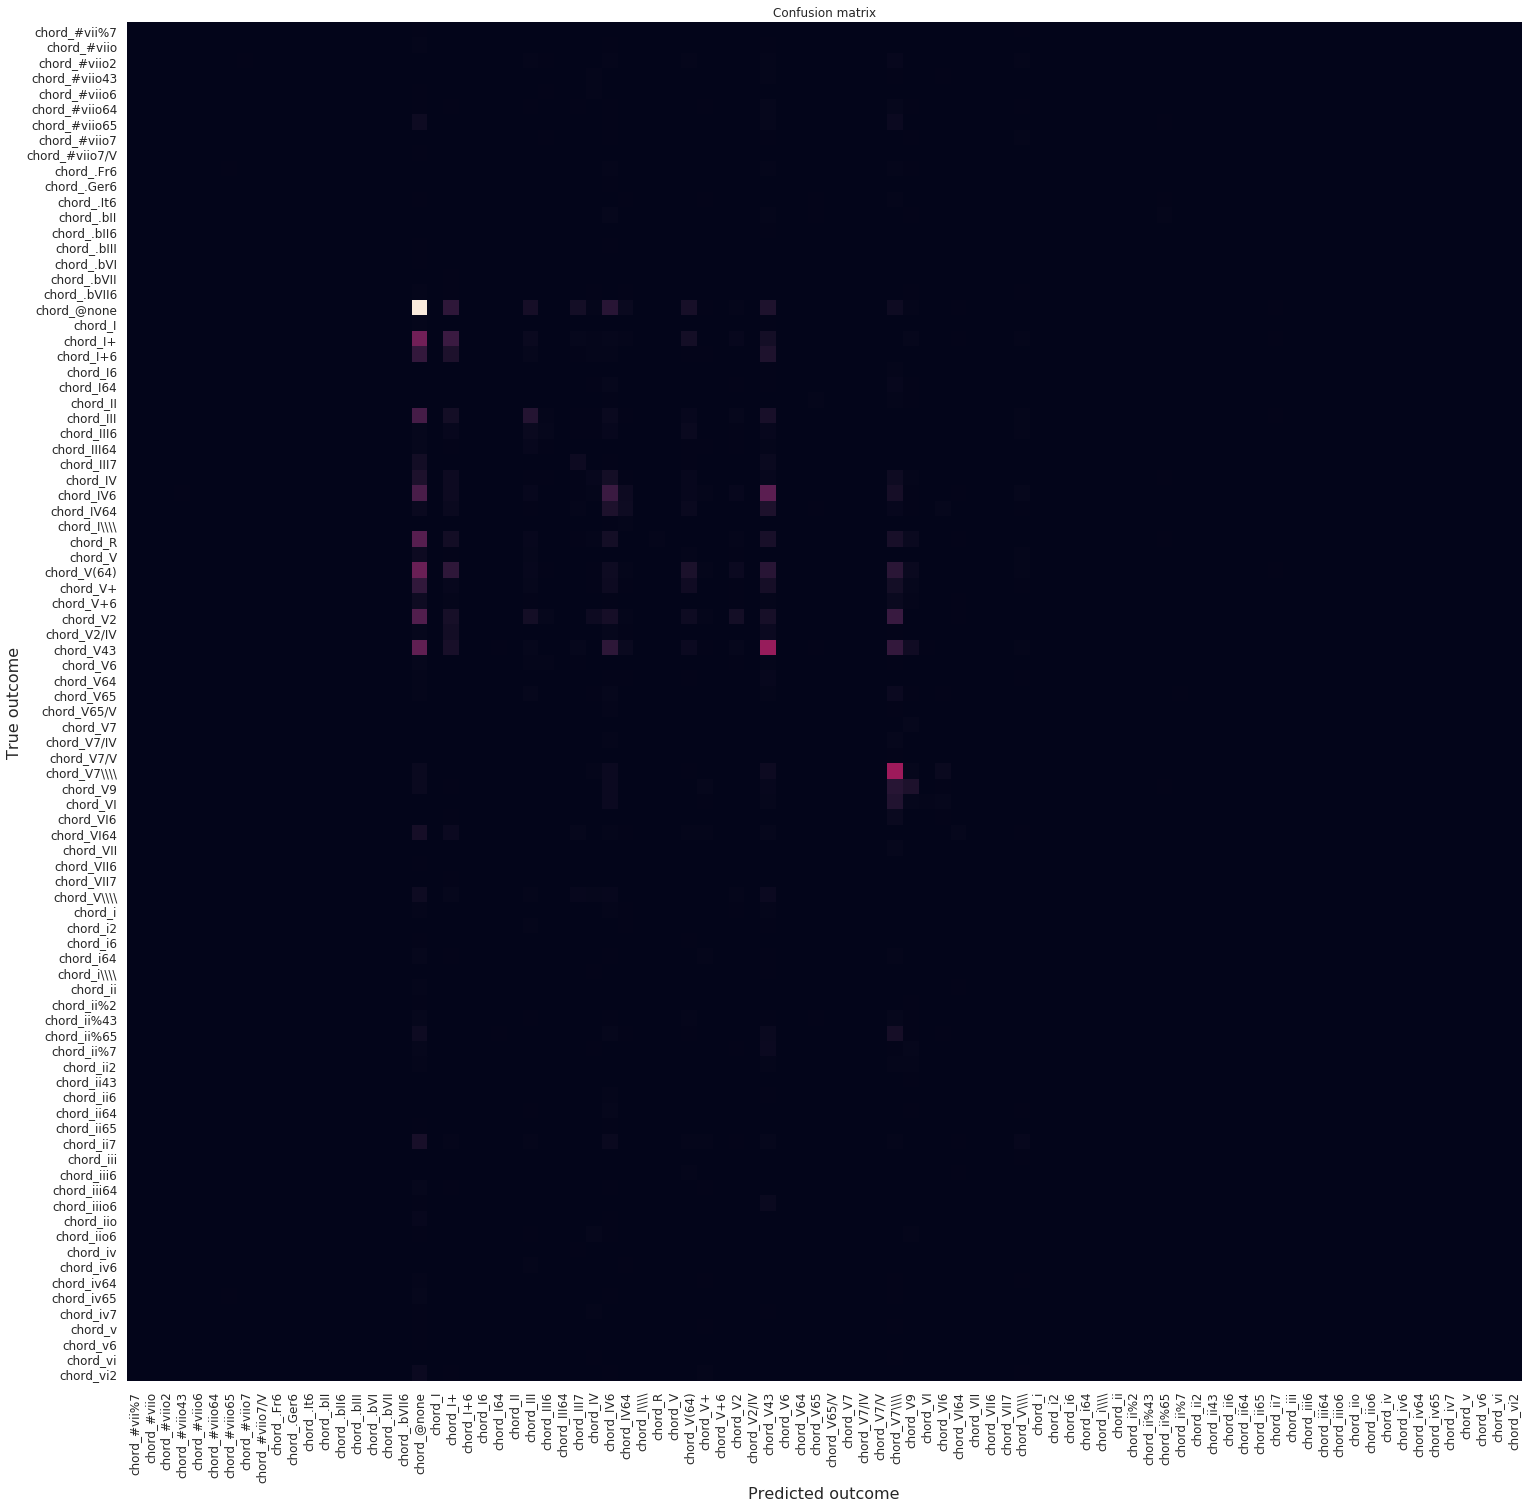

In [190]:
c = confusion_matrix(actual, predicted)

fig, ax = plt.subplots(figsize = (25,25))
sns.heatmap(c, annot=False,  annot_kws={"size": 20}, fmt='d', cbar=False)
ax.set_title('Confusion matrix')
ax.set_xticklabels(test.columns.values, fontsize=12, rotation=90)
ax.set_yticklabels(test.columns.values, fontsize=12, rotation=0)
ax.set_xlabel('Predicted outcome', fontsize=16)
ax.set_ylabel('True outcome', fontsize=16)
plt.show()

## Comparison with human performance

# Formatting stuff for the report

In [191]:
# Make the scikit learn classification report into a dataframe. 
def report2dict(cr):
    # Parse rows
    tmp = list()
    for row in cr.split("\n"):
        parsed_row = [x for x in row.split("  ") if len(x) > 0]
        if len(parsed_row) > 0:
            tmp.append(parsed_row)
    
    # Store in dictionary
    measures = tmp[0]

    D_class_data = defaultdict(dict)
    for row in tmp[1:]:
        class_label = row[0]
        for j, m in enumerate(measures):
            D_class_data[class_label][m.strip()] = float(row[j + 1].strip())
    return D_class_data

report = pd.DataFrame(report2dict(classification_report(actual, predicted))).T

/home/vidya/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [192]:
#split it into halves to make it easier to show in the report
report1 = report.iloc[:45]
report2 = report.iloc[45:]
pd.DataFrame.to_csv(report1, 'table1.1.csv')
pd.DataFrame.to_csv(report1, 'table1.2.csv')
pd.DataFrame.to_csv(report, 'table1.csv')

In [196]:
r1 = report1.reset_index()
r2 = report2.reset_index()
r2 = r2.rename(columns={'index': 'i', 'f1-score':'f', 'precision':'p', 'recall':'r', 'support':'s'})
r3 = r1.join(r2, how= 'outer')
pd.DataFrame.to_csv(r3, './results/class_report.csv')


### Legacy content: Best results for each fold without shuffling
epoch: 9 - loss: 3.1670 - acc: 0.2149 - val_loss: 3.2956 - val_acc: 0.2053

epoch: 13- loss: 2.9963 - acc: 0.2487 - val_loss: 3.1940 - val_acc: 0.2318

epoch: 15- loss: 3.0065 - acc: 0.2494 - val_loss: 3.2946 - val_acc: 0.1963

epoch: 13- loss: 3.0214 - acc: 0.2434 - val_loss: 3.2292 - val_acc: 0.2136

epoch: 13- loss: 2.9744 - acc: 0.2510 - val_loss: 3.1473 - val_acc: 0.2445

Average:

epoch: 12.6 - loss: 3.0331 - acc: 0.2414 - val_loss: 3.2321 - val_acc: 0.2183

Weights for each model stored in folder cross_fold_weights